# Sandbox: GraphConvAE

This notebook can be used for familiarization with the pytorch geometric package to train a GraphConvAE using a PPI as input.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import sys
import os
import random
import matplotlib.pyplot as plt
import community as community_louvain
from torch_geometric.data import Data
from torch import LongTensor, FloatTensor
from torch_geometric.utils import train_test_split_edges
import torch_geometric.transforms as T
import torch
from tqdm import tqdm
from torch_geometric.datasets import PPI, LastFMAsia, Planetoid, KarateClub
from torch_geometric.nn import GAE, GCNConv
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot

sys.path.append("../../../")

from src.models.ae import GraphConvAE
from src.utils.basic.visualization import plot_train_val_hist

seed = 1234
np.random.seed(seed)
random.seed(seed)
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def process_single_epoch(model, data, mode, optimizer):
    if mode == "train":
        model.train()
        optimizer.zero_grad()
        latents = model(data.x, data.edge_index)["latents"]
        # Negative edges created via negative sampling
        loss = model.loss_function(latents, data.edge_index)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        latents = model(data.x, data.edge_index)["latents"]
        loss = model.loss_function(latents, data.edge_index)

    return loss.item()


def test_gae(model, data):
    model.eval()
    latents = model.encode(data.x, data.edge_index)
    auc, ap = model.test(latents, data.edge_index, data.neg_edge_index)
    return auc, ap


def train_gae(model, data_dict, n_epochs=500, early_stopping=50):
    best_val_loss = np.infty
    loss_hist = {"train": [], "val": []}
    es_counter = 0

    best_model_weights = None
    best_epoch = -1

    for i in range(n_epochs):
        print("---" * 20)
        if es_counter < early_stopping:
            for mode in ["train", "val"]:
                loss = process_single_epoch(model, data_dict[mode], mode, optimizer)
                print("{} loss:".format(mode.upper()), loss)
                loss_hist[mode].append(loss)

                if mode == "val":
                    if loss < best_val_loss:
                        es_counter = 0
                        best_val_loss = loss
                        best_model_weights = model.state_dict()
                        best_epoch = i
                    else:
                        es_counter += 1
                    auc, ap = test_gae(model, data_dict["test"])
                    print("VAL AUC: {} \t AP: {}".format(auc, ap))
        else:
            print("Training stopped after {} epochs".format(i + 1))
            print("Best model found at epoch {}".format(best_epoch))
            break

    print("---" * 20)
    model.load_state_dict(best_model_weights)
    auc, ap = test_gae(model, data_dict["test"])
    print("TEST AUC: {} \t AP: {}".format(auc, ap))
    return model, loss_hist

<IPython.core.display.Javascript object>

---

## 1. Simple example

In the first simple example we will use the famous Zachary's Karate club graph to learn a first embedding.

In [72]:
data = KarateClub(transform=T.NormalizeFeatures())[0]
data.train_mask = data.val_mask = data.test_mask = None

<IPython.core.display.Javascript object>

The plot is visualized below where the vertices are colored by the provided class labels that were obtained by modularity clustering as described in the original publication.

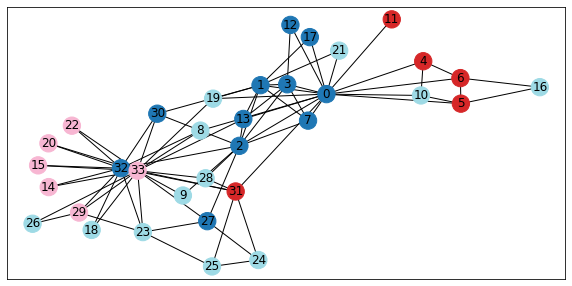

<IPython.core.display.Javascript object>

In [73]:
edge_idx = data.edge_index.cpu().numpy().transpose()
pd_edge_idx = pd.DataFrame(edge_idx, columns=["source", "target"])
graph = nx.from_pandas_edgelist(pd_edge_idx, source="source", target="target")

plt.figure(figsize=[10, 5])
pos = nx.spring_layout(graph, seed=seed)
nx.draw_networkx(graph, pos=pos, node_color=list(data.y.cpu().numpy()), cmap="tab20")

In [74]:
print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


<IPython.core.display.Javascript object>

### 1.1. Data setup

Next, we split the data into a training, validation and test set (0.7/0.1/0.2) as a size.

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)
data_split = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.2)
data_split

Data(test_neg_edge_index=[2, 15], test_pos_edge_index=[2, 15], train_neg_adj_mask=[34, 34], train_pos_edge_index=[2, 112], val_neg_edge_index=[2, 7], val_pos_edge_index=[2, 7], x=[34, 34], y=[34])

<IPython.core.display.Javascript object>

Let us construct 3 individual data sets for each portion to make the downstream analyses upwards compatible.

In [76]:
data_train = Data(x=data_split.x, edge_index=data_split.train_pos_edge_index)
data_train.edge_index = data_train.edge_index

data_val = Data(x=data_split.x, edge_index=data_split.val_pos_edge_index)
data_val.neg_edge_index = data.val_neg_edge_index

data_test = Data(x=data_split.x, edge_index=data_split.test_pos_edge_index)
data_test.neg_edge_index = data.test_neg_edge_index

data_dict = {"train": data_train, "val": data_val, "test": data_test}

<IPython.core.display.Javascript object>

---

### 1.3. Model setup

Next, we set up our Graph-convolutional Autoencoder as defined by Kipf & Welling (2016).

In [105]:
input_channels = data.num_features
hidden_dims = 4
latent_dim = 2

model = GraphConvAE(
    input_channels=input_channels, hidden_dims=hidden_dims, latent_dim=latent_dim
)
model

GraphConvAE(
  (encoder): GCNEncoder(
    (gcn1): GCNConv(34, 4)
    (relu): ReLU()
    (gcn5): GCNConv(4, 2)
  )
  (model): GAE(
    (encoder): GCNEncoder(
      (gcn1): GCNConv(34, 4)
      (relu): ReLU()
      (gcn5): GCNConv(4, 2)
    )
    (decoder): InnerProductDecoder()
  )
)

<IPython.core.display.Javascript object>

The GAE consists of two-layer graph-convolutional encoder that maps the node embedding from 1-16-8 dimensions. That is the latent space will be given by a euclidean 8 dimensional space. We apply a ReLU activation for nonlinearity after the first GCNConv layer.
The decoder is simply an innerproduct decoder that takes the sigmoid of the inner product of the latent embeddings for two nodes in order to compute a probabilistic adjacency matrix.

Next, we push everything to the GPU and define the Adam optimizer that we will use to train the model.

In [110]:
model = model.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

<IPython.core.display.Javascript object>

---

### 1.4. Model training

We will trian the models for a maximum of 300 epochs and trigger early stopping after 20 epochs.

In [111]:
model, loss_hist = train_gae(model, data_dict, n_epochs=100, early_stopping=20)

------------------------------------------------------------
TRAIN loss: 1.3408654928207397
VAL loss: 1.382948398590088
VAL AUC: 0.6844444444444445 	 AP: 0.7134896776276087
------------------------------------------------------------
TRAIN loss: 1.3221817016601562
VAL loss: 1.4084017276763916
VAL AUC: 0.6711111111111111 	 AP: 0.7017244058623369
------------------------------------------------------------
TRAIN loss: 1.3240315914154053
VAL loss: 1.3491474390029907
VAL AUC: 0.6666666666666666 	 AP: 0.6982323423702734
------------------------------------------------------------
TRAIN loss: 1.3188788890838623
VAL loss: 1.368419885635376
VAL AUC: 0.6577777777777778 	 AP: 0.690151038053675
------------------------------------------------------------
TRAIN loss: 1.309028148651123
VAL loss: 1.3672170639038086
VAL AUC: 0.6488888888888888 	 AP: 0.683130281032918
------------------------------------------------------------
TRAIN loss: 1.2989522218704224
VAL loss: 1.341264247894287
VAL AUC: 0.6266

VAL AUC: 0.6799999999999999 	 AP: 0.7240168509315514
------------------------------------------------------------
TRAIN loss: 0.8904356956481934
VAL loss: 1.5096168518066406
VAL AUC: 0.6711111111111112 	 AP: 0.713577290491991
------------------------------------------------------------
TRAIN loss: 0.9869815111160278
VAL loss: 1.2339496612548828
VAL AUC: 0.6533333333333333 	 AP: 0.7016043024663714
------------------------------------------------------------
TRAIN loss: 0.9568285942077637
VAL loss: 1.3450382947921753
VAL AUC: 0.6577777777777778 	 AP: 0.7087471596092285
------------------------------------------------------------
TRAIN loss: 0.8631646037101746
VAL loss: 1.2894928455352783
VAL AUC: 0.6577777777777778 	 AP: 0.7087471596092285
------------------------------------------------------------
Training stopped after 56 epochs
Best model found at epoch 34
------------------------------------------------------------
TEST AUC: 0.6577777777777778 	 AP: 0.7087471596092285


<IPython.core.display.Javascript object>

After training the model we will now plot the embedding space and color it by the labels.

In [108]:
data_all = KarateClub(transform=T.NormalizeFeatures())[0]
data.train_mask = data.val_mask = data.test_mask = None
latents = model(data_all.x.to(device), data_all.edge_index.to(device))["latents"]

norm_zs = StandardScaler().fit_transform(latents.detach().cpu().numpy())

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='umap-0', ylabel='umap-1'>

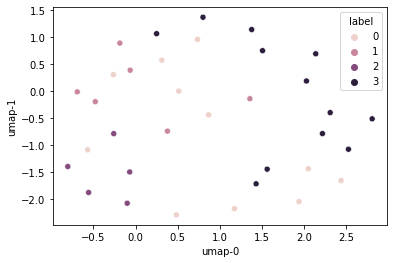

<IPython.core.display.Javascript object>

In [109]:
embs = umap.UMAP().fit_transform(norm_zs)
embs = pd.DataFrame(embs, columns=["umap-0", "umap-1"])
embs["label"] = data_all.y.cpu().numpy().astype("object")
sns.scatterplot(data=embs, x="umap-0", y="umap-1", hue="label", cmap="viridis")